In [86]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


In [87]:
train_emb_path = '/content/roberta_embeddings_train.pkl'
test_emb_path = '/content/roberta_embeddings_test.pkl'
train_labels_path = '/content/incidents_train_clean_excel.xlsx'
test_labels_path = '/content/incidents_test_clean_excel.xlsx'

In [88]:
def load_embeddings(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [89]:
X = load_embeddings(train_emb_path)

In [90]:
X_embed = np.array([np.array(emb, dtype=np.float32) for emb in X])


In [91]:
# --- Load the labels ---
X_label = pd.read_excel(train_labels_path)


In [92]:
len(X_label["hazard"].unique())

130

In [94]:
X_embed.shape

(5084, 1024)

**Hazard**

In [95]:
X_labels = X_label["hazard"]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, X_labels, test_size=0.2, random_state=42)


In [97]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [98]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [99]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [100]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [101]:
train_dataset = EmbeddingDataset(X_train, y_train)
test_dataset = EmbeddingDataset(X_test, y_test)


In [102]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [122]:
import torch
import torch.nn as nn

class LSTMTextClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_size=6, num_layers=1, num_classes=130, dropout=0.1):
        super(LSTMTextClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_size * 2, num_classes)  # hidden*2 because of bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]
        out = self.dropout(last_output)
        out = self.fc(out)
        return out




In [123]:
# Model initialization
model = LSTMTextClassifier()
# Loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# 4. Training loop
epochs = 20  # Set the number of epochs

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMTextClassifier(
  (lstm): LSTM(1024, 6, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=12, out_features=130, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [124]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print the total number of parameters
print(f"Total number of parameters: {count_parameters(model)}")

Total number of parameters: 51226


In [125]:
train_losses = []
test_losses = []

In [126]:
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Add a dummy sequence length for LSTM input: (batch_size, seq_len=1, input_size)
        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔁 Evaluate on test data **within each epoch**
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")





Epoch [1/20], Train Loss: 4.5798, Test Loss: 5.0049
Epoch [2/20], Train Loss: 3.9291, Test Loss: 5.3875
Epoch [3/20], Train Loss: 3.6251, Test Loss: 5.6745
Epoch [4/20], Train Loss: 3.5699, Test Loss: 5.8136
Epoch [5/20], Train Loss: 3.5693, Test Loss: 5.9001
Epoch [6/20], Train Loss: 3.5480, Test Loss: 5.9537
Epoch [7/20], Train Loss: 3.5322, Test Loss: 6.0017
Epoch [8/20], Train Loss: 3.4808, Test Loss: 6.0437
Epoch [9/20], Train Loss: 3.4245, Test Loss: 6.0279
Epoch [10/20], Train Loss: 3.3765, Test Loss: 6.0678
Epoch [11/20], Train Loss: 3.3413, Test Loss: 6.0748
Epoch [12/20], Train Loss: 3.3070, Test Loss: 6.0113
Epoch [13/20], Train Loss: 3.2626, Test Loss: 6.0488
Epoch [14/20], Train Loss: 3.2384, Test Loss: 6.0994
Epoch [15/20], Train Loss: 3.2177, Test Loss: 6.0731
Epoch [16/20], Train Loss: 3.1861, Test Loss: 5.9779
Epoch [17/20], Train Loss: 3.1676, Test Loss: 6.0181
Epoch [18/20], Train Loss: 3.1401, Test Loss: 6.0123
Epoch [19/20], Train Loss: 3.1112, Test Loss: 6.0577
Ep

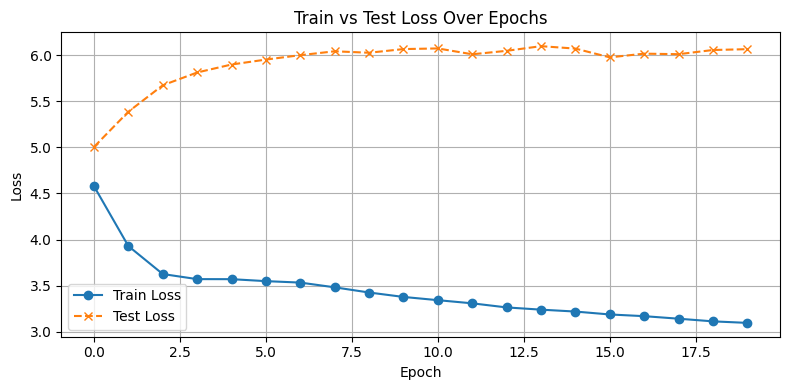

In [127]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(test_losses, label='Test Loss', marker='x', linestyle='--')
plt.title("Train vs Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
# Convert lists to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
num_classes=12

precision_macro = precision_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
recall_macro = recall_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
f1_macro = f1_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))

precision_weighted = precision_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
recall_weighted = recall_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
f1_weighted = f1_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))

accuracy = accuracy_score(all_labels, all_preds)

# Print all metrics
print(f"Macro Average Precision: {precision_macro:.4f}")
print(f"Macro Average Recall: {recall_macro:.4f}")
print(f"Macro Average F1 Score: {f1_macro:.4f}")

print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

print(f"Accuracy: {accuracy:.4f}")

Macro Average Precision: 0.0000
Macro Average Recall: 0.0000
Macro Average F1 Score: 0.0000
Weighted Average Precision: 0.0000
Weighted Average Recall: 0.0000
Weighted Average F1 Score: 0.0000
Accuracy: 0.0010


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
# Save the model (after training)
torch.save(model.state_dict(), "best_lstm_model_product.pth")
